# 2022:

In [30]:
from astropy.modeling import models, fitting
from astropy.modeling.functional_models import Gaussian2D

def ComputeModel(params):
    xcs,ycs,amps,bkgd3,sigmax,sigmay,theta = params
    amps = amps-bkgd3
    psfs1 = models.Gaussian2D(amplitude = amps, x_mean=xcs, y_mean=ycs, 
                              x_stddev=fwhm/2.35, y_stddev=fwhm/2.35, theta=0)
    psfs = psfs1(x,y)
    bkgd = np.ndarray(shape=im.shape, dtype=float)
    bkgd.fill(bkgd3)
    psf = psfs + bkgd
    return psf

(60, 60)


<IPython.core.display.Javascript object>


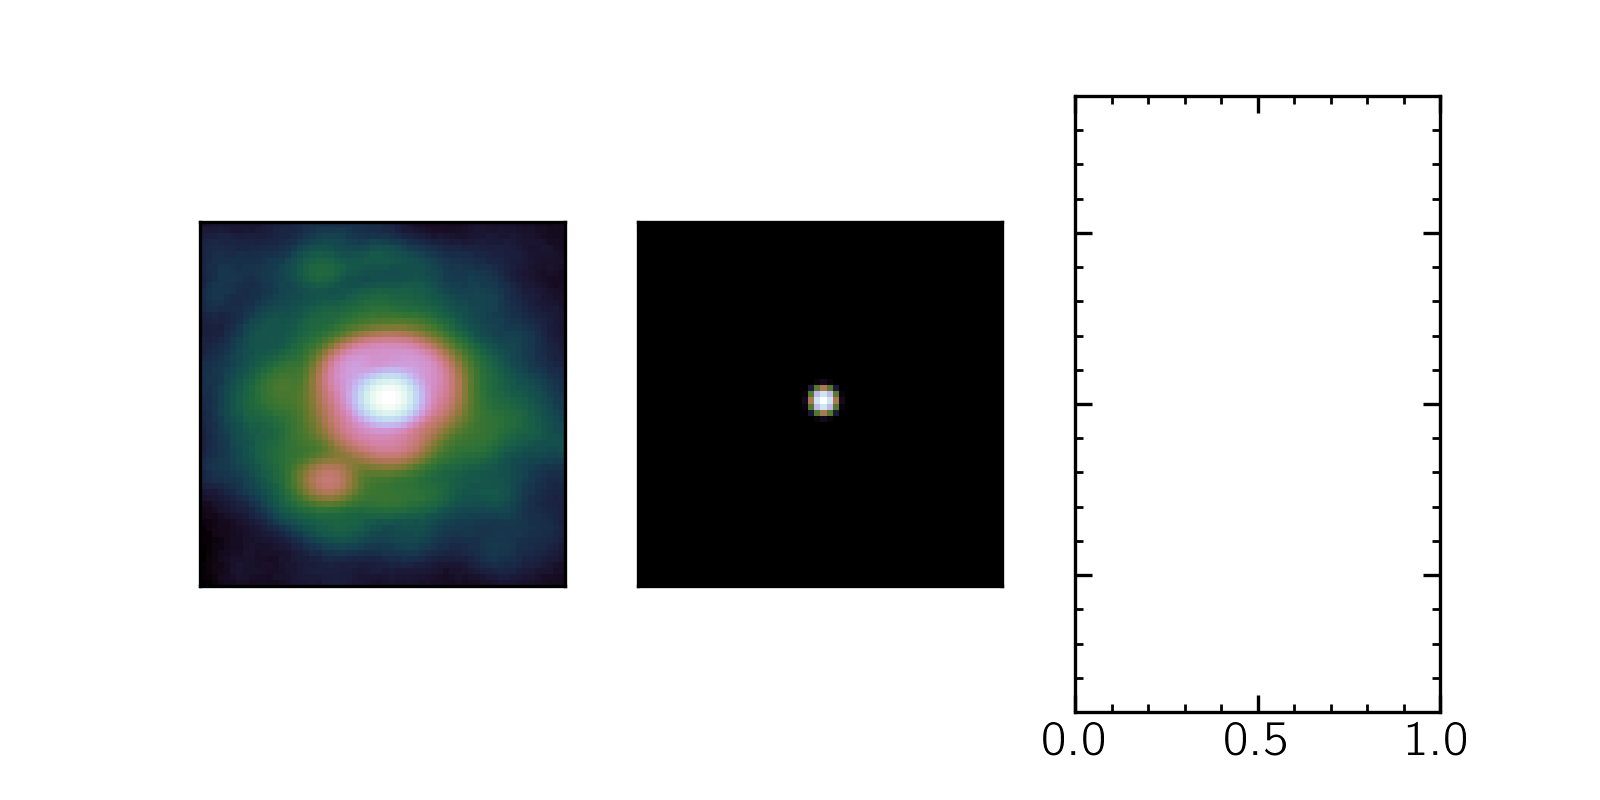

In [46]:
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, LinearStretch, LogStretch
filters = {'z':0.908,'i':0.762,'r':0.615,'g':0.525}
filt = 'z'
im = fits.getdata(filt+'_bkgdsubbed.fits')
print(im.shape)
from cliotools.bditools import lod_to_pixels
fwhm = lod_to_pixels(1., filters[filt])


cmap = 'cubehelix'
box = im.shape[0]*0.5
center = [box,box]
extent = np.array([-center[0], center[0], -center[1], center[1]]) * 0.006
xcc, ycc = 255.5 - 245.28, 255.5 - 241.72

%matplotlib notebook

plt.style.use('magrathea')
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8,4))
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im)
ax0 = axes[0]
x = ax0.imshow(im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), 
              cmap=cmap, extent = extent)
ax0.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


samples = pickle.load(open('MagAOX_HIP67506Aposition_MCMC_chains.pkl','rb'))
pos = np.array([np.mean(samples[1000:,:,0]),np.mean(samples[1000:,:,1]),
                np.mean(samples[1000:,:,2]),np.mean(samples[1000:,:,3]),
                np.mean(samples[1000:,:,4]),np.mean(samples[1000:,:,4]),
                np.mean(samples[1000:,:,6])])
pos[0] = (pos[0]-255.5)+box
pos[1] = (pos[1]-255.5)+box
y, x = np.mgrid[:im.shape[0],:im.shape[1]]
A_model = ComputeModel(pos)
ax1 = axes[1]
im = A_model
vmin, vmax = interval.get_limits(im)
ax1.imshow(im, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), 
              cmap=cmap, extent = extent)
#ax1.set_xlim(230,270)
#ax1.set_ylim(230,270)
ax1.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

#plt.imshow(im_masked - C_model, cmap = cmap)









#plt.tight_layout(w_pad = 0.7, h_pad=0)

In [40]:
A_model

array([[1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033],
       [1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033],
       [1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033],
       ...,
       [1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033],
       [1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033],
       [1644961.61802033, 1644961.61802033, 1644961.61802033, ...,
        1644961.61802033, 1644961.61802033, 1644961.61802033]])

In [41]:
pos

array([3.00034702e+001, 3.00058711e+001, 6.74304929e+007, 1.64496162e+006,
       1.11102072e+119, 1.11102072e+119, 1.00000000e-004])

# 2015

In [1]:
def injectplanet(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                 pixscale = 15.9,
                 wavelength = 'none',
                 box = 70,
                 inject_negative_signal = False
                ):
    ''' Using a template psf, place a fake planet at the desired x,y and
        contrast from the central object.  PA is measured relative to true north
        (rather than up in image)
    '''
    from cliotools.bditools import makeplanet
    
    # compute sep in pixels

    newx, newy = (xc - x), (yc - y)
    sep = np.sqrt(newx**2 + newy**2)
    pa = (np.degrees(np.arctan2(newx,-newy)) ) % 360
    
    # pa input - rotate from angle relative to north to angle relative to image up:
    #    do the opposite of what you do to derotate images
    NORTH_CLIO = -1.80
    derot = (imhdr['ROTOFF'] - 180. + NORTH_CLIO) % 360
    
    pa = (pa + derot)
        
    # Get cartesian location of planet:
    xx = sep*np.sin(np.radians((pa)))
    yy = sep*np.cos(np.radians((pa)))
    xs = np.int_(np.floor(xc-xx))
    ys = np.int_(np.floor(yc+yy))
    # Make planet from template at desired contrast
    Planet = makeplanet(template, contrast, TC)
    # Make copy of image:
    synth = image.copy()
    # Get shape of template:
    boxy, boxx = np.int_(Planet.shape[0]/2),np.int_(Planet.shape[1]/2)
    x,y = xs,ys
    ymin, ymax = y-boxy, y+boxy
    xmin, xmax = x-boxx, x+boxx
    # Correct for sources near image edge:
    delta = 0
    if ymin < 0:
        delta = ymin
        ymin = 0
        Planet = Planet[(0-delta):,:]
    if ymax > image.shape[0]:
        delta = ymax - image.shape[0]
        ymax = image.shape[0]
        Planet = Planet[:(2*boxy-delta) , :]
    if xmin < 0:
        delta = xmin
        xmin = 0
        Planet = Planet[:,(0-delta):]
    if xmax > image.shape[1]:
        delta = xmax - image.shape[1]
        xmax = image.shape[1]
        Planet = Planet[:,:(2*boxx-delta)]
    if inject_negative_signal:
        Planet = Planet * (-1)
    # account for integer pixel positions:
    if synth[ymin:ymax,xmin:xmax].shape != Planet.shape:
        try:
            synth[ymin:ymax+1,xmin:xmax] = synth[ymin:ymax+1,xmin:xmax] + (Planet)
        except:
            synth[ymin:ymax,xmin:xmax+1] = synth[ymin:ymax,xmin:xmax+1] + (Planet)
    else:
        synth[ymin:ymax,xmin:xmax] = synth[ymin:ymax,xmin:xmax] + (Planet)
    return synth

def injectplanets(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                  inject_negative_signal = True, **kwargs):
    ''' Wrapper for injectplanet() that allows for multiple fake planets in one image.
        Parameters are same as injectplanet() except sep, pa, and contrast must all be
        arrays of the same length.  **kwargs are passed to injectplanet().
    '''
    synth = image.copy()
    try:
        for i in range(len(sep)):
            synth1 = injectplanet(synth, imhdr, template, x[i], y[i], contrast[i], TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
            synth = synth1.copy()
    except:
        synth = injectplanet(synth, imhdr, template, x, y, contrast, TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
    return synth

class SyntheticSignal(object):
    def __init__(self, k, Star, x, y, C, boxsize = 50,
                sciencecube = [], refcube = [], 
                template = [], TC = None, use_same = True, verbose = True,
                inject_negative_signal = True, wavelength = 3.77
                ):
        ''' Class for creating and controling images with synthetic point source signals ("planet") injected.
        '''
        self.k = k
        self.Star = Star
        self.x = x
        self.y = y
        self.C = C
        self.verbose = verbose
        self.sciencecube = sciencecube
        self.refcube = refcube
        self.template = template
        box = sciencecube.shape[1] / 2
        
        synthcube = np.zeros(np.shape(self.sciencecube))
        # Inject planet signal into science target star:
        center = (0.5*((self.sciencecube.shape[2])-1),0.5*((self.sciencecube.shape[1])-1))
        # inject signal:
        for i in range(self.sciencecube.shape[0]):
            if TC == None:
                from cliotools.bditools import contrast
                # Get template constrast of refcube to sciencecube
                TC = contrast(self.sciencecube[i],self.templatecube[i],center,center)
            imhdr = fits.getheader(k['filename'].loc[i])
            synth = injectplanets(self.sciencecube[i], imhdr, self.template, x, y, C, TC, box, box,
                                  wavelength = wavelength, box = box, 
                                        inject_negative_signal = inject_negative_signal)
            synthcube[i,:,:] = synth
                
        self.synthcube = synthcube.copy()
        

/var/folders/tm/1xdh6wyn1qv7mhy_c10d5c_w0000gn/T/ipykernel_26808/3061164833.py:107: RuntimeWarning: divide by zero encountered in log10
  model = 10**(-(-2.5*np.log10(template) + C)/2.5)
/var/folders/tm/1xdh6wyn1qv7mhy_c10d5c_w0000gn/T/ipykernel_26808/3061164833.py:107: RuntimeWarning: invalid value encountered in log10
  model = 10**(-(-2.5*np.log10(template) + C)/2.5)


<IPython.core.display.Javascript object>


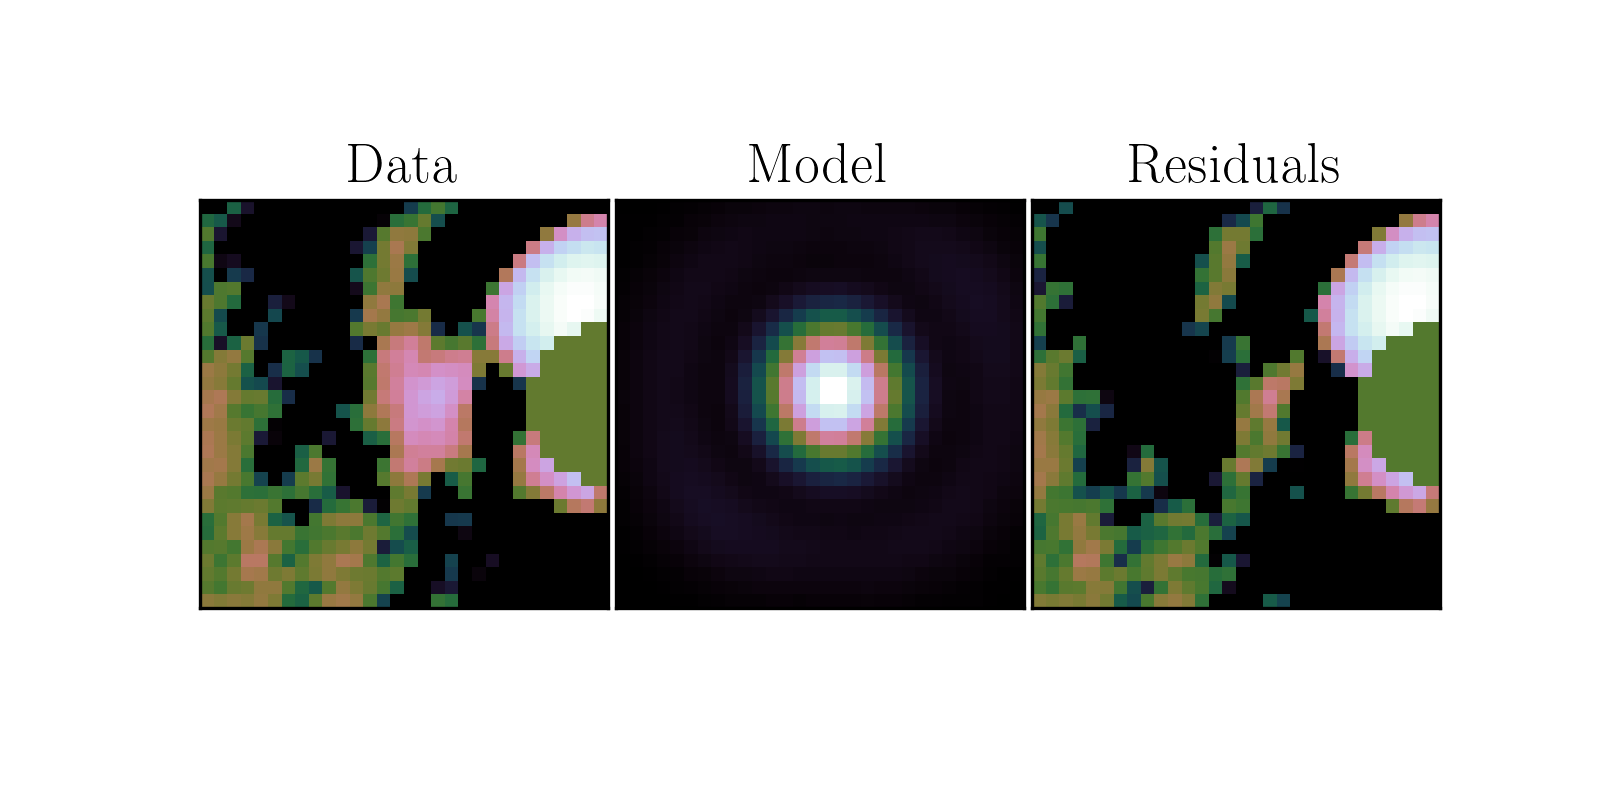

(30, 30)
0.8108437454948743


In [135]:
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, LinearStretch, LogStretch

C = 5.61 - 0.5
x = 75.76
y = 90.88

from cliotools.bditools import contrast
path = "BDI1350/box90/"
sp = pickle.load(open('../../../bdi/system-parameters.pkl','rb'))
fullpath = '../../../bdi/'+path

Star = 'A'

# Open saved cleaned cubes:
astamp = fits.getdata('../../../bdi/'+path+'acube_box90_bpf-best.fits')
bstamp = fits.getdata('../../../bdi/'+path+'bcube_box90_bpf-best.fits')

K_klip = sp[path+'K_klipA']
box = astamp.shape[1] * 0.5
inner_mask = 0.5
from cliotools.bditools import lod_to_pixels
inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box

k = pd.read_csv('CleanList.csv', comment='#')

xc,yc = 0.5*((2*box)-1), 0.5*((2*box)-1)
xs,ys = x,y

template = np.median(bstamp, axis=0)
sciencecube = astamp
refcube = bstamp
center = (xc, yc)
TC = contrast(np.median(sciencecube, axis=0),template,center,center)


############# residuals
SynthCube = SyntheticSignal(k, Star, xs, ys, C,
                            sciencecube = sciencecube, refcube = refcube,
                            template = template, TC = TC, boxsize = box, inject_negative_signal = True)

from cliotools.bdi import BDI
SynthCubeObjectBDI2 = BDI(k, fullpath, K_klip = K_klip, 
                    boxsize = box, normalize = True, normalizebymask = False,       
                    inner_mask_core = True,        
                    inner_radius_format = 'pixels',
                    inner_mask_radius = inner_mask,        
                    outer_mask_annulus = True,     
                    outer_radius_format = 'pixels',
                    outer_mask_radius = outer_mask,       
                    mask_cval = 0,       
                    subtract_radial_profile = False,          
                    verbose = False,               
                    acube = SynthCube.synthcube,    
                    bcube = SynthCube.refcube   
                   )
# Do klip reduction:
SynthCubeObjectBDI2.Reduce(interp='bicubic',
             rot_cval=0.,
             mask_interp_overlapped_pixels = True
            ) 

################# data
from cliotools.bdi import BDI
BDIObject = BDI(k, fullpath, K_klip = K_klip, 
                    boxsize = box, normalize = True, normalizebymask = False,       
                    inner_mask_core = True,        
                    inner_radius_format = 'pixels',
                    inner_mask_radius = inner_mask,        
                    outer_mask_annulus = True,     
                    outer_radius_format = 'pixels',
                    outer_mask_radius = outer_mask,       
                    mask_cval = 0,       
                    subtract_radial_profile = False,          
                    verbose = False,               
                    acube = sciencecube,    
                    bcube = refcube   
                   )
# Do klip reduction:
BDIObject.Reduce(interp='bicubic',
             rot_cval=0.,
             mask_interp_overlapped_pixels = True
            ) 



################# model
from cliotools.bditools import makeskycube, rotate_clio

x1, y1 = 755, 171
skycube = makeskycube(path, x1,y1,k,int(box), write_skycube=False)
center = (0.5*((skycube.shape[2])-1),0.5*((skycube.shape[1])-1))

smallest = np.min([skycube.shape[0],templatecube.shape[0]])
i=0
imhdr = fits.getheader(k['filename'][i])
synthcube = skycube.copy()
for i in range(astamp.shape[0]):
    imhdr = fits.getheader(k['filename'][i])
    synthcube[i,:,:] = injectplanets(skycube[i], imhdr, template, xs, ys, C, TC, 
                                      center[0], center[1], box = box, wavelength = 3.77, 
                                     inject_negative_signal = False)
from cliotools.bditools import rotate_clio
sss = rotate_clio(synthcube[0],fits.getheader(k['filename'][0]))
######

model = 10**(-(-2.5*np.log10(template) + C)/2.5)


##################### plot
cmap = 'cubehelix'
%matplotlib notebook
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,4))
#gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 0.05], width_ratios=[1,1,1])
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1,1,1])
gs.update(wspace=0.02, hspace=0.05)

ax0 = fig.add_subplot(gs[0, 0])
im = BDIObject.A_Reduced[int(ys-15):int(ys+15),int(xs-15):int(xs+15)]
print(im.shape)
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im)
#ax0 = axes[0]
x = ax0.imshow(im, norm = ImageNormalize(vmin=vmin+1.8e-4, vmax=vmax, stretch=LogStretch()), 
              cmap=cmap)
ax0.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax0.set_title('Data')
#cax0 = fig.add_subplot(gs[1, 0])
#cbar0 = plt.colorbar(x,cax=cax0, orientation = 'horizontal', format='%.0e')
#cbar0.ax.tick_params(labelsize=10, rotation=45) 

#ax1 = axes[1]
ax1 = fig.add_subplot(gs[0, 1])
im1 = model[int(yc-15):int(yc+15),int(xc-15):int(xc+15)]
vmin, vmax = interval.get_limits(im1)
print(vmin)
x = ax1.imshow(im1, cmap=cmap, norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch()), 
              )
ax1.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax1.set_title('Model')
#cax1 = fig.add_subplot(gs[1, 1])
#cbar1 = plt.colorbar(x,cax=cax1, orientation = 'horizontal', format='%.0e')


#ax2 = axes[2]
ax2 = fig.add_subplot(gs[0, 2])
im2 = SynthCubeObjectBDI2.A_Reduced[int(ys-15):int(ys+15),int(xs-15):int(xs+15)]
vmin, vmax = interval.get_limits(im2)
x = ax2.imshow(im2, norm = ImageNormalize(vmin=vmin+1.8e-4, vmax=vmax, stretch=LogStretch()), cmap=cmap)
ax2.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax2.set_title('Residuals')
#cax2 = fig.add_subplot(gs[1, 2])
#cbar2 = plt.colorbar(x,cax=cax2, orientation = 'horizontal', format='%.0e')

plt.savefig('../best_best_final_plots/datamodelresiduals_2015.png', dpi=300, bbox_inches='tight')